# Capítulo 3. CLASIFICACION

En el capítulo 1 mencionamos que las tareas más comunes del aprendizaje supervisado eran la regresión (predicción de valores) y la clasificación (predicción de clases). En el capítulo 2 exploramos la tarea de regresión, predicción de precios de las viviendas, usando varios algoritmos, como la regresión lineal, árboles de decisión y bosques aletarios. Ahora centraremos nuestra atención en los sistemas de clasificación.

# MNIST

En este capítulo usaremos el dataset de MNIST, que es un conjunto de 70.000 pequeñas imágenes de dígitos escritos a mano por estudiantes y empleados de la Oficina Censal de EEUU. Cada imagen está etiquetada con el dígito que representa. Este conjunto ha sido tan estudiado que a menudo se le denomina el "Hello World" del Machine Learning: cualquier persona que se inicie con un nuevo algoritmo de clasificación tendrá curiosidad de ver cómo se ejecutará en MNIST. Cada vez que alguien aprende Machine Learning, tarde o temprano se enfrentará a MNIST.

Scikit-Learn proporciona muchas funciones de ayuda para descargar datasets populares. MNIST es uno de ellos. El siguiente código obtiene el dataset MNIST (Por defecto, Scikit-Learn cachea los datasets descargados en un directorio llamado: *\\$HOME/scikit_learn_data*):

In [1]:
# imports comunes
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Hacer las salidas de este notebook estables a través de ejecuciones
np.random.seed(42)

# Hacemos algunos ajustes a los gráficos
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

Generalmente, los dataset cargados por Scikit-Learn tienen una estructura similar a un diccionario, incluyendo:

+ una clave `DESCR` describiendo el dataset
+ una clave `data` conteniendo un array con una fila por cada instancia y una columna por cada característica
+ una clave `target` conteniendo un array con las etiquetas (objetivo)

Echemos un vistazo a estos arrays:

In [5]:
X, y = mnist["data"], mnist["target"]
print(f"X: {X.shape}\ny: {y.shape}")

X: (70000, 784)
y: (70000,)


Hay 70.000 imágenes y cada imagen tiene 784 características. Esto es así porque cada imagen son 28x28 pixels, donde cada característica representa un pixel de intensidad, de 0 (blanco) a 255 (negro). Echemos un vistazo a un dígito del dataset. Todo lo que necesitamos es tomar el vector de características de una instancia, redimensionarlo a una matriz de 28 × 28 y mostrarlo usando la función `imshow()` de Matplotlib:

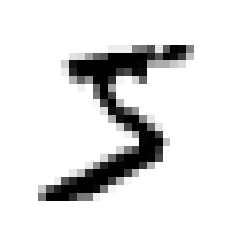

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

Parece que es un 5, y de hecho es lo que nos dice su etiqueta:

In [5]:
y[0]

'5'

Fijémonos que la etiqueta es una cadena. Preferimos números, así que vamos a convertir `y` a enteros:

In [6]:
y = y.astype(np.uint8)

In [7]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [8]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Veamos algunas imágenes más del dataset de MNIST para que tener una impresión de la complejidad de la tarea de clasificación.

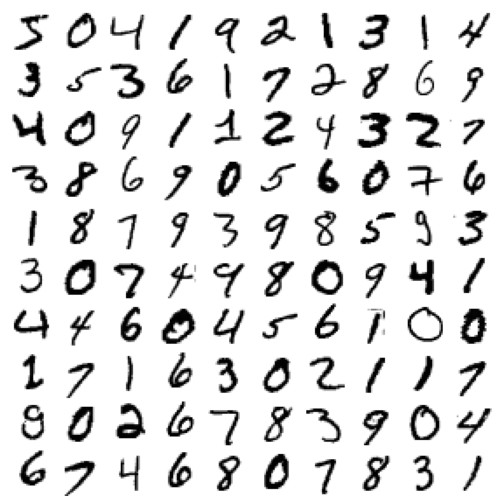

In [9]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

¡Espera! Siempre debemos crear un conjunto de pruebas y apartarlo antes de inspeccionar los datos de cerca. El conjunto de datos MNIST ya está dividido en un conjunto de entrenamiento (las primeras 60.000 imágenes) y un conjunto de prueba (las últimas 10.000 imágenes):

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

El conjunto de entrenamiento ya está mezclado para nosotros, lo cual es bueno, ya que esto garantiza que todas las particiones de validación cruzada serán similares (no queremos que ninguna partición omita algún dígito). Además, algunos algoritmos de aprendizaje son sensibles al orden de las instancias de entrenamiento y tienen un bajo rendimiento si obtienen muchas instancias similares seguidas. Al barajar el conjunto de datos se garantiza que esto no suceda (mezclar los datos puede ser una mala idea en algunos contextos, por ejemplo si estamos trabajando con datos de series temporales, como los precios de mercado de stock o las condiciones meteorológicas).

# Entrenar un clasificador binario

Vamos a simplificar el problema y vamos a tratar de identificar un dígito (por ejemplo, el número 5). Este "detector de 5" será un ejemplo de un *clasificador binario*, capaz de distinguir solo entre dos clases, 5 y no-5 . Creemos los vectores objetivo de esta tarea de clasificación:

In [11]:
y_train_5 = (y_train == 5)  # True para todos los 5s, False para el resto de dígitos
y_test_5 = (y_test == 5)

Bien, ahora vamos a elegir un clasificador y a entrenarlo. Un buen lugar para comenzar es con un clasificador *Stochastic Gradient Descent* (SGD), utilizando la clase `SGDClassifier` de Scikit-Learn. Este clasificador tiene la ventaja de ser capaz de manejar conjuntos de datos muy grandes de manera eficiente. Esto se debe en parte a que SGD se ocupa de las instancias de entrenamiento de forma independiente, una a la vez (lo que también hace que SGD sea adecuado para el *aprendizaje online*), como veremos más adelante. Vamos a crear un `SGDClassifier` y entrenarlo en el conjunto de entrenamiento completo:

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

---

`SGDClassifier` se basa en la aleatoriedad durante el entrenamiento (de ahí el nombre de "estocástico"). Si queremos resultados reproducibles debemos establecer el parámetro `random_state`.

---

Ahora podemos usarlo para detectar imágenes del número 5:

In [13]:
sgd_clf.predict([some_digit])

array([ True])

El clasificador supone que esta imagen representa un 5 (`True`). Parece que acertó en este caso en particular. Ahora vamos a evaluar la ejecución del modelo.

# Medidas del rendimiento

Evaluar un clasificador es a menudo significativamente más complicado que evaluar un regresor, por lo que dedicaremos gran parte de este capítulo a este asunto. Existen muchas medidas disponibles del rendimiento, así que cojamos otro café y preparémonos para aprender muchos conceptos y acrónimos.

## Medida de la precisión usando Validación Cruzada

Una buena forma de evaluar un modelo es usar validación cruzada, como vimos en el capítulo 2.

---

**Implementación de la validación cruzada**

Ocasionalmente necesitaremos más control sobre el proceso de validación cruzada del que Scikit-Learn nos proporciona. En esos casos, podemos implementar la validación cruzada por nosotros mismos; en realidad es bastante sencillo. El siguiente código hace más o menos lo mismo que la función `cross_val_score()` de Scikit-Learn y muestra el mismo resultado:

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # muestra 0.9502, 0.96565 and 0.96495

C:\Program Files\Python38\lib\site-packages\sklearn\model_selection\_split.py:292: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.95035
0.96035
0.9604


La clase `StratifiedFold` ejecuta un muestreo estratificado para generar particiones que contengan un ratio representantivo de cada clase. En cada iteración el código crea un clon del clasificador, entrena ese clon en las particiones de entrenamiento y realiza las predicciones en la partición de prueba. Después cuenta el número de predicciones correctas y devuelve el ratio de predicciones correctas.

---

Vamos a usar  la función `cross_val_score()` para evaluar nuestro model `SGDClassifier` usando validación cruzada, con 3 particiones. Recordemos que la validación cruzada significa dividir el conjunto de entrenamiento en K-particiones (en este caso, tres), después realizamos las predicciones y evaluamos en cada partición usando un modelo entrenado en las particiones restantes.

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy", n_jobs=-1)

array([0.95035, 0.96035, 0.9604 ])

¿Más del 95% de precisión (relación de predicciones correctas) en todos los folds de validación cruzada? Esto es increíble, ¿no? Bueno, antes de que nos emocionemos demasiado pensemos en un clasificador muy tonto que simplemente clasifica cada imagen en la clase "no 5":

In [16]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy", n_jobs=-1)

array([0.91125, 0.90855, 0.90915])

¡Así es, tiene más del 90% de precisión! Esto se debe simplemente a que solo el 10% de las imágenes son 5, por lo que si siempre adivina que una imagen no es un 5, tendrá razón aproximadamente el 90% de las veces. Vence a Nostradamus.

Esto demuestra por qué la precisión generalmente no es la medida de rendimiento preferida para los clasificadores, especialmente cuando se trata de *conjuntos de datos sesgados* (es decir, cuando algunas clases son mucho más frecuentes que otras).

## Matriz de Confusión

Una forma mucho mejor de evaluar la ejecución de un clasificador es la *matriz de confusión*. La idea general es contar el número de veces que las instancias de la clase A son clasificadas como clase B. Por ejemplo, para saber el número de veces que el clasificador confunde imágenes de 5s con 3s, miraría en la fila 5ª y columna 3ª de la matriz de confusión.

Para calcular la matriz de confusión, primero necesitamos disponer de un conjunto de predicciones, así podemos compararlas con los objetivos reales. Podríamos realizar las predicciones en el conjunto de prueba pero mantengámoslo sin tocar por ahora (recuerda que solo queremos usar el conjunto de prueba muy al final del proyecto, una vez que tenemos un clasificador listo para poner en producción). En su lugar, utilizaremos la función `cross_val_predict()`.

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, n_jobs=-1)

Al igual que la función `cross_val_score`, `cross_val_prediction` ejecuta validación cruzada, pero en lugar de devolver las puntuaciones de la evaluación, devuelve las predicciones realizadas en cada partición de prueba. Esto significa que obtenemos una predicción limpia por cada instancia en el conjunto de entrenamiento ("limpia" significa que la predicción se ha realizado por un modelo que nunca ha visto los datos durante el entrenamiento).

Ahora ya estamos preparados para obtener la matriz de confusión usando `confusion_matrix()`. Solo hay que pasar las clases objetivo (`y_train_5`) y las clases predichas (`y_train_pred`):

In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Cada fila en una matriz de confusión representa una *clase real*, mientras que cada columna representa una *clase predicha*. La primera fila de esta matriz considera imágenes no-5 (la *clase negativa*): 53.892 de ellas se clasificaron correctamente como no-5 (se llaman *verdaderos negativos*), mientras que las 687 restantes se clasificaron erróneamente como 5s (*falsos positivos*). La segunda fila considera las imágenes de 5s (la *clase positiva*): 1.891 se clasificaron erróneamente como no-5s (*falsos negativos*), mientras que los 3.530 restantes se clasificaron correctamente como 5s (*verdaderos positivos*). Un clasificador perfecto solo tendría verdaderos positivos y verdaderos negativos, por lo que su matriz de confusión tendría valores distintos de cero solo en su diagonal principal (desde arriba a la izquierda a la parte inferior derecha):

In [20]:
y_train_perfect_predictions = y_train_5  # pretendemos alcanzar la perfección
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

La matriz de confusión proporciona mucha información, pero a veces podemos preferir una métrica más concisa. Una interesante es la precisión de las predicciones positivas: esto se llama la *precisión* del clasificador.

$precision = \frac{VP}{VP + FP}$

Es decir, precisión = verdaderos positivos / (verdaderos positivos + falsos  positivos)

Una forma trivial de tener una precisión perfecta es hacer una sola predicción positiva y asegurarse de que sea correcta (precisión = 1/1 = 100%). Esto no sería muy útil ya que el clasificador ignoraría todas las instancias, excepto una positiva. Por lo tanto, la precisión se usa normalmente junto con otra métrica llamada *recall*, también llamada *sensibilidad* o *ratio de verdaderos positivos* (TPR): esta es la proporción de instancias positivas que el clasificador detecta correctamente.

$sensibilidad = \frac{VP}{VP + FN}$

Es decir, sensibilidad o recall = verdaderos positivos / (verdaderos positivos + falsos negativos)

![confusion_matrix](images/ch03/confusion_matrix.png)

## Precisión y Sensibilidad

Scikit-Learn proporciona varias funciones para calcular métricas de clasificadores, incluyen la precisión y la sensibilidad:

In [21]:
from sklearn.metrics import precision_score, recall_score

print(f"Precisión:    {precision_score(y_train_5, y_train_pred)}") # == 3530 / (3530 + 687)
print(f"Sensibilidad: {recall_score(y_train_5, y_train_pred)}")    # == 3530 / (3530 + 1891)

Precisión:    0.8370879772350012
Sensibilidad: 0.6511713705958311


Parece que ahora nuestro detector de 5s no se ve tan brillante como lo hizo cuando calculamos su precisión. Cuando dice que una imagen representa un 5, es correcto solo el 83,7% de las veces. Además, solo detecta el 65,1% de los 5s.

A menudo es conveniente combinar precisión y sensibilidad en una sola métrica llamada *puntuación* $F_1$ (*F1 score*), en particular si necesitamos una forma sencilla de comparar dos clasificadores. La puntuación $F_1$ es la *media armónica* de precisión y sensibilidad (ecuación 3-3). Mientras que la media regular trata a todos los valores por igual, la media armónica otorga mucho más peso a los valores bajos. Como resultado, el clasificador solo obtendrá una puntuación alta en $F_1$ si tanto la sensibilidad como la precisión son altas.

$F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{sensibilidad}} = 2 \times \frac{precision\, \times\, sensibilidad}{precision\, +\, sensibilidad} = \frac{VP}{VP\,+\,\frac{FN\,+\,FP}{2}}$

Para calcular la puntuación $F_1$ simplemente llamamos a la función `f1_score()`:

In [22]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

La puntuación de $F_1$ favorece a los clasificadores que tienen una precisión y sensibilidad similares. Esto no es siempre lo que queremos: en algunos contextos, nos importará la precisión y en otros contextos realmente nos importa la sensibilidad. Por ejemplo, si entrenamos a un clasificador para que detecte videos que sean seguros para los niños, probablemente preferiremos un clasificador que rechace muchos videos buenos (sensibilidad baja) pero que mantenga solo los seguros (alta precisión), en lugar de un clasificador que tenga mucho mayor sensibilidad, pero que permita que algunos videos realmente malos se muestren en nuestro producto (en tales casos, es posible que deseemos agregar un control humano para verificar la selección de videos del clasificador). Por otro lado, supongamos que entrenamos a un clasificador para detectar ladrones en las imágenes de vigilancia: probablemente esté bien si su clasificador tiene solo un 30% de precisión, siempre que tenga un 99% de sensibilidad (seguro, los guardias de seguridad recibirán algunas alertas falsas, pero casi todos los ladrones serán atrapados).

Desafortunadamente, no podemos tenerlo de las dos maneras: aumentar la precisión reduce la sensibilidad, y viceversa. Esto se llama *equilibro de precisión/sensibilidad*.

## Equilibrio precisión/Sensibilidad

Para entender este equilibrio, veamos cómo `SGDCClassifier` toma sus decisiones de clasificación. Para cada instancia, calcula una puntuación basada en una *función de decisión* y si esa puntuación es mayor que un umbral, asigna la instancia a la clase positiva, o bien la asigna a la clase negativa. En la siguiente figura se muestran algunos dígitos ubicados desde la puntuación más baja de la izquierda hasta la puntuación más alta de la derecha. Supongamos que el *umbral de decisión* se ubica en la flecha central (entre los dos 5): encontrará 4 verdaderos positivos (5s reales) a la derecha de ese umbral, y un falso positivo (en realidad un 6). Por lo tanto, con ese umbral la precisión es del 80% (4 de 5). Pero de 6 reales 5s, el clasificador solo detecta 4, por lo que la sensibilidad es del 67% (4 de 6). Ahora, si aumentamos el umbral (movemos la flecha a la derecha), el falso positivo (el 6) se convierte en un verdadero negativo, lo que aumenta la precisión (hasta el 100% en este caso), pero un verdadero positivo se convierte en un falso negativo, disminuyendo la sensibilidad hasta el 50%. Por el contrario, bajar el umbral aumenta la sensibilidad y reduce la precisión.

![decision_threshold](images/ch03/decision_threshold.png)

Scikit-Learn no nos permite establecer el umbral directamente, pero nos da acceso a las puntuaciones de decisión que utiliza para hacer predicciones. En lugar de llamar al método `predict()` del clasificador, llamamos a su método `decision_function()`, que devuelve una puntuación para cada instancia y luego hace predicciones basadas en esas puntuaciones utilizando cualquier umbral que deseemos:

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [24]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

`SGDClassifier` usa un umbral igual a 0, como vemos. Por tanto, devuelve el mismo resultado que el método `predict()` (es decir, `True`). Vamos a subir el umbral:

In [25]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Esto confirma que elevar el umbral disminuye la sensibilidad. La imagen en realidad representa un 5 y el clasificador lo detecta cuando el umbral es 0, pero lo pierde cuando el umbral se incrementa a 8.000. 

Entonces, ¿cómo podemos decidir qué umbral usar? Para ello, primero deberemos obtener las puntuaciones de todas las instancias en el conjunto de entrenamiento utilizando la función `cross_val_predict()` nuevamente, pero esta vez especificando que queremos que devuelva las puntuaciones de decisión en lugar de las predicciones:

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function", n_jobs=-1)

Ahora, con estas puntuaciones podemos calcular la precisión y la sensibilidad para todos los umbrales posibles utilizando la función `precision_recall_curve()`:

In [27]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Por último, podemos dibujar la precisión y la sensibilidad como funciones del umbral:

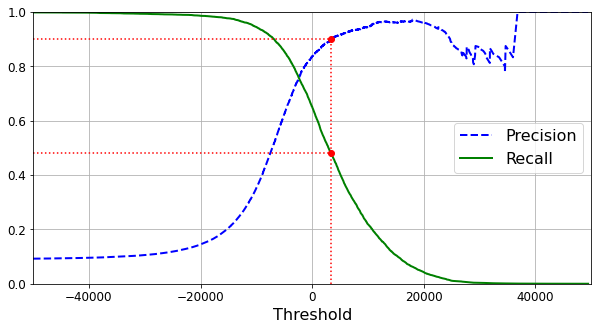

In [28]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(10, 5))                                                                 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro");

---

Quizás nos preguntemos por qué la curva de precisión es más irregular que la de sensibilidad. La razón es que la precisión algunas veces puede caer cuando sube el umbral (aunque en general subirá). Para comprender por qué, volvamos a mirar la figura donde hablábamos del equilibrio entre precisión y sensibilidad y observemos qué pasa cuando comenzamos desde el umbral central y lo movemos solo un dígito a la derecha: la precisión disminuye de 4/5 (80%)  a 3/4 (75%). Por otro lado, la sensibilidad solo disminuye cuando se incrementa el umbral, lo que explica por qué la curva se ve suave.

---

Otra forma de seleccionar un buen equlibrio precisión/sensibilidad es trazar la precisión directamente contra la sensibilidad:

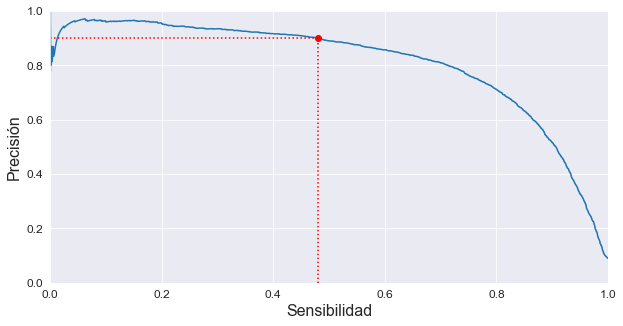

In [29]:
def plot_precision_vs_recall(precisions, recalls):
    ax = sns.lineplot(x=recalls, y=precisions)
    plt.xlabel("Sensibilidad", fontsize=16)
    plt.ylabel("Precisión", fontsize=16)
    plt.axis([0, 1, 0, 1])
    
sns.set_style("darkgrid")
figure, axs = plt.subplots(figsize=(10,5))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4799, 0.4799], [0., 0.9], "r:")
plt.plot([0.0, 0.4799], [0.9, 0.9], "r:")
plt.plot([0.4799], [0.9], "ro");

Se puede ver que la precisión realmente comienza a caer bruscamente en torno al 80% de sensibilidad. Es probable que queramos seleccionar un equilibrio de precisión/sensibilidad justo antes de esa caída, por ejemplo, en aproximadamente el 60% de sensibilidad. Pero, por supuesto, la elección depende de nuestro proyecto. 

Así que supongamos que decidimos apuntar a una precisión del 90%. Buscamos en el primer gráfico (acercando un poco el zoom) y descubrimos que necesitamos usar un umbral de aproximadamente 3.300. Para ser más precisos podemos buscar el menor umbral que nos da al menos el 90% de precisión (`np.argmax()` nos devolverá el primer índice del valor máximo, que en este caso significa el primer valor `True`):

In [30]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

Para hacer predicciones (en el conjunto de entrenamiento por ahora), en lugar de llamar al método `predict()` del clasificador, podemos ejecutar este código:

In [31]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

Verifiquemos la precisión y la sensibilidad de las predicciones:

In [32]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [33]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

¡Genial, ya tenemos un clasificador con una precisión del 90%! Como podemos ver es bastanta fácil crear un clasificador con virtualmente cualquier precisión que queramos: solo hay que establecer un umbral suficientemente alto y ya está. Hmmm, no tan rápido. Un clasificador de alta precisión no es muy útil si la sensibilidad es demasiado baja.

---

Si alguien dice "alcancemos el 99% de precisión", debemos preguntarle "¿Con qué sensibilidad?"

---

## La curva ROC

La curva ROC (*receiver operating characteristic*) es otra herramienta común que se utiliza con los clasificadores binarios. Es muy similar a la curva de precisión/sensibilidad, pero en lugar de trazar la precisión frente a la sensibilidad, la curva ROC traza el *ratio de verdaderos positivos* (otro nombre para la sensibilidad) contra la *tasa de falsos positivos* (FPR). El FPR es el ratio de casos negativos que se clasifican incorrectamente como positivos. Es igual a uno menos la *tasa de verdaderos negativos* (TNR), que es el ratio de casos negativos que se clasifican correctamente como negativos. El TNR también se llama *especificidad*. Por lo tanto, la curva ROC representa la *sensibilidad* (recall) versus 1 - *especificidad*.

Para dibujar la curva ROC, lo primero que necesitamos es calcular el TPR y FPR para varios valores de umbral, usando la función `roc_curve()`:

In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Entonces podemos dibujar el FPR contra el TPR:

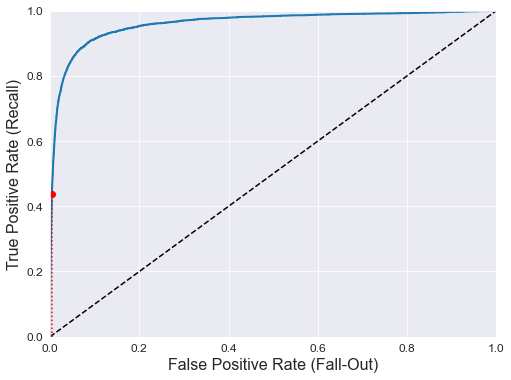

In [35]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                         
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") 
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  
plt.plot([4.837e-3], [0.4368], "ro");

Una vez más, hay un equilibrio: cuanto mayor sea la sensibilidad (TPR), más falsos positivos (FPR) produce el clasificador. La línea de puntos representa la curva ROC de un clasificador puramente aleatorio. Un buen clasificador se mantiene lo más alejado posible de esa línea (hacia la esquina superior izquierda).

Una forma de comparar los clasificadores es medir el *área bajo la curva* (AUC). Un clasificador perfecto tendrá una ROC AUC igual a 1, mientras que un clasificador puramente aleatorio tendrá una AUC ROC igual a 0.5.

In [36]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

---

Dado que la curva ROC es muy similar a la curva precisión/sensibilidad (o PR), es posible que nos preguntemos cuál de ellas debemos elegir. Como regla general, deberíamos preferir la curva PR siempre que la clase positiva sea rara o cuando nos preocupen más los falsos positivos que los falsos negativos, y la curva ROC al contrario. Por ejemplo, al observar la curva ROC anterior (y la puntuación ROC AUC), podemos pensar que el clasificador es realmente bueno. Pero esto se debe principalmente a que existen pocos positivos (5s) comparados con los negativos (no-5s). En contraste, la curva PR deja claro que el clasificador tiene margen de mejora (la curva podría estar más cerca de la esquina superior derecha).

---

Vamos a entrenar un `RandomForestClassifier` y comparemos su curva ROC y la puntuación ROC AUC con el `SGDClassifier`. Primero, necesitamos obtener puntuaciones para cada instancia en el conjunto de entrenamiento. Pero debido a la forma en que funciona, la clase `RandomForestClassifier` no tiene un método de `decision_function()`. En su lugar, tiene un método `predict_proba()`. Los clasificadores de Scikit-Learn generalmente tienen uno u otro. El método `predict_proba()` devuelve una matriz que contiene una fila por instancia y una columna por clase, cada una conteniendo la probabilidad de que la instancia dada pertenezca a la clase dada (por ejemplo, 70% de probabilidad de que la imagen represente un 5):

In [37]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba", n_jobs=-1)

Pero para trazar una curva ROC necesitamos puntuaciones, no probabilidades. Una solución simple es usar la probabilidad de la clase positiva como puntuación:

In [38]:
y_scores_forest = y_probas_forest[:, 1]   # score = proba de clase positiva
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

Ahora ya estamos listos para dibujar la curva ROC. Es útil dibujar primero la curva ROC para ver cómo se comparan:

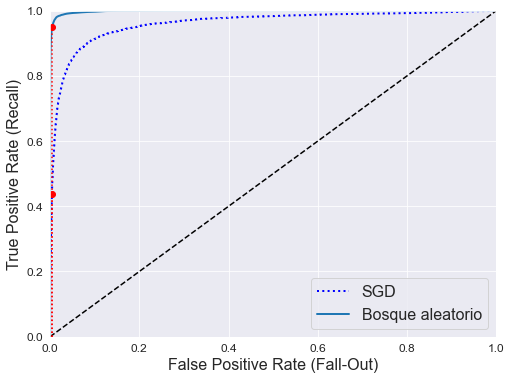

In [39]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Bosque aleatorio")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)

Como podemos ver la curva ROC de `RandomForestClassifier` es mucho mejor que la de `SGDClassifier`: está mucho más cerca de la esquina superior izquierda. En consecuencia, la puntuación ROC AUC es significativamente mejor:

In [40]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

Intente medir las puntuaciones de precisión y sensibilidad: debe encontrar una precisión del 99% y una sensibilidad del 86.6%. ¡No está mal!

In [41]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, n_jobs=-1)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [42]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

Ahora sabemos cómo entrenar clasificadores binarios, elegir la métrica adecuada para nuestra tarea, evaluar nuestros clasificadores utilizando validación cruzada, seleccionar el equilibrio de precisión/sensibilidad que se adapte a nuestras necesidades y comparar varios modelos utilizando curvas ROC y puntuaciones AUC ROC. Ahora tratemos de detectar algo más que sólo 5s.

# Clasificación Multiclase

Mientras que los clasificadores binarios distinguen entre dos clases, los *clasificadores multiclase* (también denominados *clasificadores multinomiales*) pueden distinguir entre más de dos clases. Algunos algoritmos (como Random Forest o Naive Bayes) son capaces de manejar multiples clases directamente. Otros (como Support Vector Machine o clasificadores lineales) son clasificadores estrictamente binarios. Sin embargo, existen varias estrategias que podemos usar para ejecutar clasificación multiclase usando múltiples clasificadores binarios.

Por ejemplo, una forma de crear un sistema que pueda clasificar imágenes de dígitos en 10 clases (del 0 al 9) es entrenar 10 clasificadores binarios, uno por cada dígito (un 0-detector, un 1-detector, un 2-detector, etc.). Luego, cuando queremos clasificar una imagen, obtenemos la puntuación de decisión de cada clasificador para esa imagen y seleccionamos la clase cuyo clasificador obtiene la puntuación más alta. Esto se denomina estrategia de *uno contra todos* (one-versus-all, OvA) (también llamada *uno contra el resto*).

Otra estrategia es entrenar un clasificador binario para cada par de dígitos: uno para distinguir 0s y 1s, otro para distinguir 0s y 2s, otro para 1s y 2s, y así sucesivamente. Esto se denomina estrategia de *uno contra uno* (one-versus-one, OvO). Si hay N clases, necesitamos entrenar N × (N - 1) / 2 clasificadores. Para el problema MNIST, esto significa entrenar a ¡45 clasificadores binarios! Cuando quieras clasificar una imagen, debes ejecutar la imagen en los 45 clasificadores y ver qué clase gana la mayoría de los duelos. La principal ventaja de OvO es que cada clasificador solo necesita ser entrenado en la parte del conjunto de entrenamiento para las dos clases que debe distinguir.

Algunos algoritmos (como los clasificadores Support Vector Machine) escalan mal con el tamaño del conjunto de entrenamiento, por lo que para estos algoritmos se prefiere OvO, ya que es más rápido entrenar a muchos clasificadores en conjuntos de entrenamiento pequeños que entrenar a pocos clasificadores en conjuntos de entrenamiento grandes. Sin embargo, para la mayoría de los algoritmos de clasificación binaria, se prefiere OvA.

Scikit-Learn detecta cuándo intentas utilizar un algoritmo de clasificación binaria para una tarea de clasificación multiclase y ejecuta automáticamente OvA (excepto para los clasificadores SVM para los que utiliza OvO). Probemos esto con el `SGDClassifier`:

In [43]:
sgd_clf.fit(X_train[:1000], y_train[:1000])   # y_train no y_train_5
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

¡Eso ha sido fácil! Este código entrena al `SGDClassifier` en el conjunto de entrenamiento utilizando las clases objetivo originales de 0 a 9 (`y_train`), en lugar de las clases objetivo de 5 contra todos (`y_train_5`). Luego hace una predicción (una correcta en este caso). Internamente Scikit-Learn realmente entrenó a 10 clasificadores binarios, obtuvo sus puntuaciones de decisión para la imagen y seleccionó la clase con la puntuación más alta.

Para ver en detalle este caso, podemos llamar al método `decision_function()`. En lugar de devolver solo una puntuación por instancia, ahora devuelve 10 puntuaciones, una por clase:

In [44]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-6049581.97985829, -6138036.45541781, -3886281.38604606,
         -604692.42366776, -6948311.32017537,   914498.2913215 ,
        -6855666.78647961, -3866146.33271573, -4016434.08430155,
        -3209136.89074954]])

La mayor puntuación es la que corresponde a la clase 5:

In [45]:
np.argmax(some_digit_scores)

5

In [46]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [47]:
sgd_clf.classes_[5]

5

---

Cuando se entrena un clasificador, almacena la lista de clases objetivo en su atributo `classes_`, ordenado por valor. En este caso, el índice de cada clase en el array `classes_` coincide convenientemente con la clase en sí misma (es decir, la clase en el índice 5 es la clase 5), pero en general no seremos tan afortunados.

---

Si queremos forzar a Scikit-Learn a usar uno-contra-uno o uno-contra-todos, podemos usar las clases `OneVsOneClassifier` o `OneVsRestClassifier`. Simplemente creamos una instancia y pasamos un clasificador binario a su constructor. Por ejemplo, este código crea un clasificador multiclase usando la estrategia OvO, basado en un clasificador `SGDClassifier`:

In [48]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train[:1000], y_train[:1000])
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [49]:
len(ovo_clf.estimators_)

45

Entrenar un `RandomForestClassifier` es tan fácil como esto:

In [50]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

Esta vez, Scikit-Learn no tuvo que ejecutar OvA u OvO porque los clasificadores de Random Forest pueden clasificar directamente las instancias en varias clases. Podemos llamar a `predict_proba()` para obtener la lista de probabilidades que el clasificador asignó a cada instancia para cada clase:

In [51]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

Vemos que el clasificador está bastante seguro de su predicción: 0.90 para el 5º índice del array significa que el modelo estima un 90% de probabilidad de que la imagen representa un 5. También piensa que la imagen podría ser un 2 o un 3(a un 1% y 8% de probabilidad, respectivamente).

Ahora evaluemos estos clasificadores. Como de costumbre, utilizaremos la validación cruzada. Evaluemos la precisión del `SGDClassifier` usando la función `cross_val_score()`:

In [52]:
cross_val_score(sgd_clf, X_train, y_train, cv=3,
               scoring="accuracy", n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


array([0.87365, 0.85835, 0.8689 ])

Consigue más del 85% en todas las particiones de prueba. Si utilizáramos un clasificador aleatorio, obtendríamos un 10% de precisión, por lo que no es una puntuación tan mala, pero podemos hacerlo mucho mejor. Por ejemplo, simplemente escalando las entradas (como se explica en el Capítulo 2) aumentaríamos la precisión por encima del 90%:

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, 
                scoring="accuracy", n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.7min finished


array([0.8983, 0.891 , 0.9018])

# Análisis de error

Por supuesto, si se tratara de un proyecto real, seguiríamos los pasos de la lista de verificación de proyectos de machine learning: explorar las opciones de preparación de datos, probar varios modelos, hacer una lista de los mejores y ajustar sus hiperparámetros usando `GridSearchCV`, y automatizar tanto como sea posible, como hicimos en el capítulo anterior. Aquí, asumiremos que hemos encontrado un modelo prometedor y que deseamos encontrar formas de mejorarlo. Una forma de hacerlo es analizar los tipos de errores que comete.

Primero, podemos mirar la matriz de confusión. Necesitamos hacer predicciones usando la función `cross_val_predict()`, luego llamar a la función `confusion_matrix()`, como hicimos antes:

In [54]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3,
                                n_jobs=-1)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

Esto son muchos números. A menudo es más conveniente mirar una representación de imagen de la matriz de confusión, usando la función `matshow()` de Matplotlib:

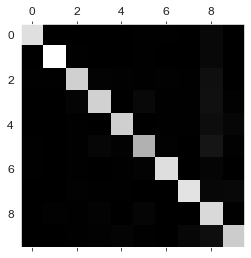

In [55]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.grid(False)
plt.show()

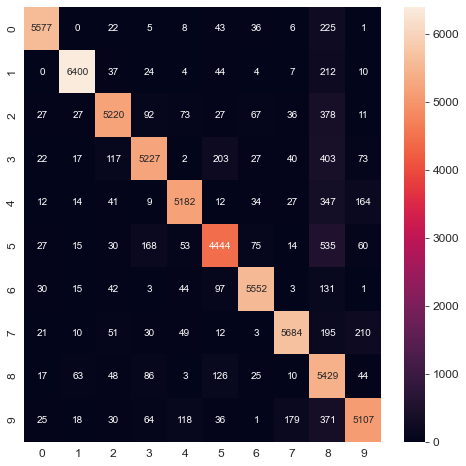

In [56]:
# Otra forma de representarlo
fig = plt.figure(figsize=(8,8))
ax = sns.heatmap(conf_mx, annot=True, fmt="d")

Esta matriz de confusión parece bastante buena, ya que la mayoría de las imágenes están en la diagonal principal, lo que significa que se clasificaron correctamente. Los 5s se ven un poco más oscuros que los otros dígitos, lo que podría significar que hay menos imágenes de 5s en el conjunto de datos o que el clasificador no funciona tan bien con los 5s como en otros dígitos. De hecho, podemos verificar que es así en ambos casos. 

Centremos el gráfico en los errores. Primero, dividamos cada valor en la matriz de confusión por el número de imágenes en la clase correspondiente, de modo que pueda comparar los ratios de error en lugar del número absoluto de errores (lo que haría que las clases abundantes se vean injustamente malas):

In [57]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_con_mx = conf_mx / row_sums

Ahora llenemos la diagonal con ceros para mantener solo los errores y dibujamos el resultado:

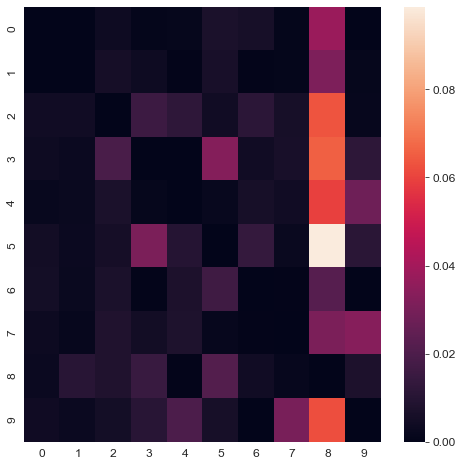

In [58]:
np.fill_diagonal(norm_con_mx, 0)
fig = plt.figure(figsize=(8,8))
ax = sns.heatmap(norm_con_mx)

Ahora podemos ver claramente los tipos de errores que comete el clasificador. Recuerdemos que las filas representan clases reales, mientras que las columnas representan clases predichas. La columna para la clase 8 es bastante brillante, lo que indica que muchas imágenes se clasifican erróneamente como 8. Sin embargo, la fila para la clase 8 no es mala, nos dice que los 8 en general se clasifican correctamente como 8s. Observemos que la matriz de confusión no es necesariamente simétrica. Podemos ver que que los 3s y los 5s se confunde a menudo (en ambas direcciones).

El análisis de la matriz de confusión a menudo nos puede dar ideas sobre cómo mejorar nuestro clasificador. Mirando este gráfico parece que nuestros esfuerzos deberían dedicarse a mejorar los falsos 8s. Por ejemplo, podríamos intentar recopilar más datos de entrenamiento para dígitos que parezcan 8s (pero que no lo sean), así el clasificador puede aprender a distinguirlos de los 8s reales. O podemos diseñar nuevas funciones que ayuden al clasificador; por ejemplo, escribir un algoritmo para contar el número de bucles cerrados (por ejemplo, 8 tiene dos, 6 tiene uno, 5 no tiene). O podemos preprocesar las imágenes (por ejemplo, utilizando Scikit-Image, Pillow o OpenCV) para hacer que algunos patrones se destaquen más, como los bucles cerrados.

Analizar errores individuales también puede ser una buena forma de obtener información sobre lo que está haciendo su clasificador y por qué está fallando, pero es más difícil y lleva más tiempo. Por ejemplo, vamos a dibujar ejemplos de 3 y 5:

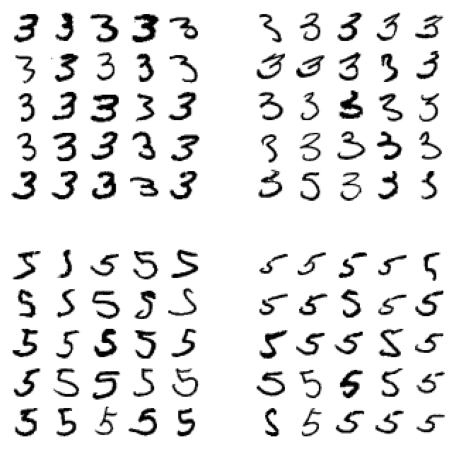

In [59]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

Los dos bloques 5 × 5 de la izquierda muestran los dígitos clasificados como 3 y los dos bloques 5 × 5 de la derecha muestran las imágenes clasificadas como 5s. Algunos de los dígitos en los que el clasificador se equivoca (por ejemplo, en los bloques de abajo a la izquierda y de arriba a la derecha) están tan mal escritos que incluso un humano podría tener problemas para clasificarlos (por ejemplo, el 5 en la 8ª fila y la 1ª columna realmente se ve como un 3). Sin embargo, la mayoría de las imágenes mal clasificadas nos parecen errores obvios y es difícil entender por qué el clasificador cometió los errores que cometió (pero recordemos que nuestro cerebro es un sistema fantástico de reconocimiento de patrones y nuestro sistema visual realiza un complejo preprocesamiento antes de que cualquier información alcance nuestra consciencia, así que el hecho de que  parezca simple no significa que los sea). La razón es que usamos un `SGDClassifier` simple, que es un modelo lineal. Todo lo que hace es asignar un peso por clase a cada píxel y cuando ve una nueva imagen simplemente suma las intensidades de píxeles ponderadas para obtener una puntuación para cada clase. Por lo tanto, como 3s y 5s difieren solo por unos pocos píxeles este modelo los confundirá fácilmente.

La diferencia principal entre 3 y 5 es la posición de la línea pequeña que une la línea superior con el arco inferior. Si dibuja un 3 con la unión ligeramente desplazada hacia la izquierda el clasificador podría clasificarlo como un 5 y viceversa. En otras palabras, este clasificador es bastante sensible al desplazamiento y rotación de la imagen. Por lo tanto, una forma de reducir la confusión 3/5 sería preprocesar las imágenes para garantizar que estén bien centradas y no demasiado rotadas. Esto probablemente ayudará a reducir otros errores también.

# Clasificación multietiqueta

Hasta ahora cada instancia siempre se ha asignado a una sola clase. En algunos casos querremos que nuestro clasificador genere varias clases por cada instancia. Por ejemplo, consideremos un clasificador de reconocimiento de rostros: ¿qué debería hacer si reconociera a varias personas en la misma foto? Evidentemente, debería etiquetar a cada persona que reconozca. Digamos que el clasificador se entrena para reconocer tres rostros: Alicia, Tomás y Carlos, entonces cuando le mostramos una fotografía de Alicia y Carlos, su salida sería [1, 0, 1] (que significa "Alicia sí, Tomás no, Carlos sí). Estos sistemas de clasificación que proporcionan mútiples etiquetas binarias se denominan sistemas de *clasificación multietiqueta*.

Todavía no entraremos en el reconocimiento facial, pero veamos un ejemplo más simple, solo para propósitos ilustrativos:

In [60]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Este código crea una matriz `y_multilabel` que contiene dos etiquetas objetivo para cada imagen de dígito: la primera indica si el dígito es grande (7, 8 o 9) y la segunda indica si es impar o no. Las siguientes líneas crean una instancia de `KNeighborsClassifier` (que admite la clasificación de varias capas) y la entrenamos utilizando la matriz de múltiples objetivos. Ahora podemos hacer una predicción y comprobar que genera dos etiquetas:

In [61]:
knn_clf.predict([some_digit])

array([[False,  True]])

¡Y lo hace bien! El dígito 5 no es grande (`False`) y es impar (`True`).

Hay muchas formas de evaluar un clasificador multiclase y seleccionar la métrica correcta realmente depende de nuestro proyecto. Por ejemplo, un enfoque es medir la puntuación de $F_1$ para cada etiqueta individual (o cualquier otra métrica de clasificador binario analizada anteriormente), luego simplemente calcular la puntuacion promedio. Este código calcula la puntuación promedio de $F_1$ en todas las etiquetas:

In [62]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, 
                                    n_jobs=-1, verbose=2)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 15.4min finished


0.976410265560605

Esto asume que todas las etiquetas son igualmente importantes, lo que puede no ser el caso. En particular, si tenemos muchas más fotos de Alicia que de Tomás o Carlos, es posible que deseemos darle más peso a la puntuación del clasificador en las fotografías de Alicia. Una opción simple es dar a cada etiqueta un peso igual a su *support* (es decir, el número de instancias con esa etiqueta objetivo). Para hacer esto, simplemente establecemos `average = "weighted"` en el código anterior.

# Clasificación Multioutput

El último tipo de tarea de clasificación que vamos a discutir aquí se llama *clasificación multisalida* (*multioutput*). Es simplemente una generalización de la clasificación multietiqueta en la que cada etiqueta puede ser multiclase (es decir, puede tener más de dos valores posibles).

Para ilustrar esto, construyamos un sistema que elimine el ruido de las imágenes. Tomará como entrada una imagen de dígitos ruidosos, y (con suerte) emitirá una imagen de dígitos limpios, representada como una matriz de intensidades de píxeles, al igual que las imágenes MNIST. Observemos que la salida del clasificador es multilabel (una etiqueta por píxel) y que cada etiqueta puede tener varios valores (la intensidad de píxeles varía de 0 a 255). Es así un ejemplo de un sistema de clasificación multioutput.

---

La línea entre la clasificación y la regresión es a veces borrosa, como en este ejemplo. Podría decirse que predecir la intensidad de pixel es más similar a la regresión que a la clasificación. Además, los sistemas multioutput no están limitados a tareas de clasificación; podemos tener un sistema que genera múltiples etiquetas por instancia, incluyendo tanto etiquetas de clase como etiquetas de valor.

---

Comencemos creando los conjuntos de entrenamiento y prueba tomando las imágenes del MNIST y agregando ruido a las intensidades de sus píxeles mediante la función `randint()` de NumPy. Las imágenes objetivo serán las imágenes originales:

In [63]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Echemos un vistazo a una imagen del conjunto de prueba (sí, estamos indagando en los datos de prueba, por lo que deberíamos estar frunciendo el ceño en este momento):

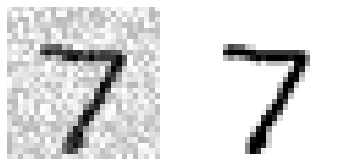

In [64]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])

A la izquierda está la imagen de entrada ruidosa y a la derecha está la imagen de destino limpia. Ahora entrenemos al clasificador y hagamos que limpie esta imagen:

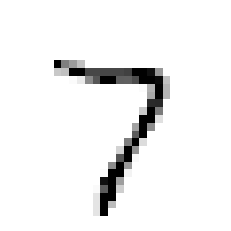

In [65]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

¡Se ve lo suficientemente cerca del objetivo! Con esto concluye nuestro recorrido de clasificación. Con suerte, ahora deberíamos saber cómo seleccionar buenas métricas para las tareas de clasificación, elegir el compromiso de precisión / sensibilidad adecuado, comparar clasificadores y, en general, construir buenos sistemas de clasificación para una variedad de tareas.

# Material Extra

## Clasificador dummy

In [66]:
from sklearn.dummy import DummyClassifier

dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

C:\Program Files\Python38\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


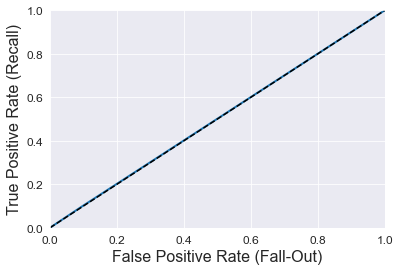

In [67]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

## Clasificador KNN

In [68]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [69]:
y_knn_pred = knn_clf.predict(X_test)

In [70]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_knn_pred)

0.9714

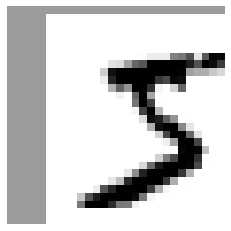

In [71]:
from scipy.ndimage.interpolation import shift

def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [72]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [73]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [74]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [75]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [76]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])

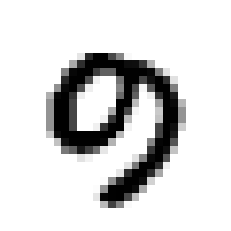

In [77]:
plot_digit(ambiguous_digit)

# Ejercicios

## Ej.1 Un clasificador de MNIST con una precisión de más del 97%

**Intenta crear un clasificador para el conjunto de datos MNIST que logre una precisión de más del 97% en el conjunto de prueba. Sugerencia: `KNeighborsClassifier` funciona bastante bien para esta tarea; solo tienes que encontrar buenos valores de hiperparámetros (intenta usar grid search para los hiperparámetros `weights` y `n_neighbors`).**

¡Atención! este proceso dura 2 h. aprox.

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=4)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 92.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=4,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [10]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [11]:
grid_search.best_score_

0.9716166666666666

In [12]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

## Ej.2 Data augmentation

***Escribe una función que pueda desplazar una imagen MNIST en cualquier dirección (izquierda, derecha, arriba o abajo) en un píxel. Luego, para cada imagen en el conjunto de entrenamiento, crea cuatro copias desplazadas (una por dirección) y agrégalas al conjunto de entrenamiento. Finalmente, entrena a su mejor modelo en este conjunto de entrenamiento ampliado y mide su precisión en el conjunto de prueba. ¡Debemos observar que el modelo funciona aún mejor ahora! Esta técnica de crecimiento artificial del conjunto de entrenamiento se denomina aumento de datos o expansión del conjunto de entrenamiento.***

In [13]:
from scipy.ndimage.interpolation import shift

In [14]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

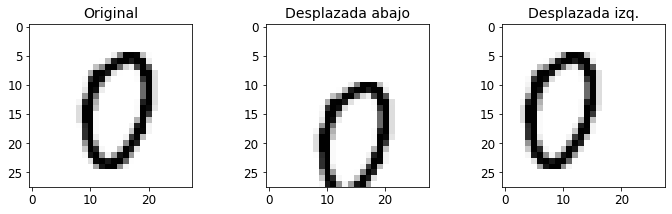

In [15]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Desplazada abajo", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Desplazada izq.", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")

In [16]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [17]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [18]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [19]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [20]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

Simplemente aumentando los datos, hemos obtenido un aumento de la precisión de un 0.5%.

## Ej.3 Trastear con el dataset del *Titanic*

***Aborda el dataset del Titanic. Un buen lugar para comenzar es en [Kaggle](https://www.kaggle.com/c/titanic).***

El objetivo es predecir si un pasajero sobrevivió o no en función de atributos como su edad, sexo, clase de pasajero, dónde se embarcaron, etc.

En primer lugar, lógate en [Kaggle](https://www.kaggle.com/) y ve al [desafío Titanic](https://www.kaggle.com/c/titanic) para descargar `train.csv` y `test.csv`. Grábalos en el directorio `datasets/titanic`.

Lo siguiente vamos cargar los datos:

In [21]:
import os

TITANIC_PATH = os.path.join("data", "titanic")

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [23]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

Los datos ya están dividios en un conjunto de entrenamiento y un conjunto de prueba. Sin embargo, los datos de prueba no contienen las etiquetas: nuestro objetivo es entrenar al mejor modelo que podamos usando los datos de entrenamiento, luego hagamos nuestras predicciones sobre los datos de la prueba y carguémoslos en Kaggle para ver nuestra puntuación final.

Echemos un vistazo a las primeras filas del conjunto de entrenamiento:

In [24]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Los atributos tienen el siguiente significado:

* **Survived**: este es el objetibo, 0 significa que el pasajero no sobrevivió, mientra que 1 significa que él/ella sobrevivió.
* **Pclass**: clase del pasajero.
* **Name**, **Sex**, **Age**: auto-explicativo
* **SibSp**: cuántos hermanos y cónyuges del pasajero a bordo del Titanic.
* **Parch**: cuántos hermanos y padres del pasajero a bordodel Titanic.
* **Ticket**: identificador del billete
* **Fare**: precio pagado (en libras)
* **Cabin**: número de camarote del pasajero
* **Embarked**: dónde embarcó el pasajero en el Titanic

Obtengamos más información para ver cuántos datos faltan:

In [25]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


De acuerdo, los atributos **Age**, **Cabin** y **Embarked** son a veces nulos (menos de 891 no nulos), especialmente **Cabin** (77% son nulos). Ignoraremos la **Cabin** por ahora y nos centraremos en el resto. El atributo **Age** tiene aproximadamente un 19% de valores nulos, por lo que tendremos que decidir qué hacer con ellos. Reemplazar valores nulos con la mediana de edad parece razonable.

Los atributos **Name** y **Ticket** pueden tener algún valor, pero serán un poco difíciles de convertir en números útiles que un modelo pueda consumir. Entonces, por ahora, los ignoraremos.

Echemos un vistazo a los atributos numéricos:

In [26]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Solo **Sobrevivió** el 38%:(Eso es lo suficientemente cercano al 40%, por lo que la precisión será una medida razonable para evaluar nuestro modelo.
* La **tarifa media** fue de £ 32.20, lo que no parece tan caro (pero probablemente era mucho dinero en ese entonces).
* La media de **Edad** era menor de 30 años.

Verifiquemos que el objetivo sea 0 o 1:

In [27]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [28]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [29]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

El atributo `Embarked` nos dice dónde se embarcó el pasajero: C = Cherbourg, Q = Queenstown, S = Southampton.

**Nota**: el siguiente código utiliza una combinación de `Pipeline`,` FeatureUnion` y un `DataFrameSelector` personalizado para preprocesar algunas columnas de manera diferente. Desde Scikit-Learn 0.20, es preferible usar un `ColumnTransformer`, como en el capítulo anterior.

Ahora construyamos nuestras pipelines de preprocesamiento. Reutilizaremos el `DataframeSelector` que creamos en el capítulo anterior para seleccionar atributos específicos del `DataFrame`:

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Construyamos un pipeline para los atributos numéricos:

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [32]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

También necesitaremos un *imputer* para las columnas categóricas de cadena (el `SimpleImputer` normal no funciona en esas):

In [33]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [34]:
from sklearn.preprocessing import OneHotEncoder

Ahora podemos construir el pipeline para los atributos categóricos:

In [35]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [36]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

Finalmente unamos los pipelines numérico y categórico:

In [37]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

Ahora tenemos un buen pipeline de preprocesamiento que toma los datos sin procesar y genera características de entrada numéricas que podemos alimentar a cualquier modelo de Machine Learning que queramos.

In [38]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

No olvidemos obtener las etiquetas:

In [39]:
y_train = train_data["Survived"]

Ahora estamos listos para entrenar un clasificador. Empecemos con un SVC:

In [40]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Genial, nuestro modelo está entrenado. Usémoslo para realizar predicciones en el conjunto de prueba:

In [41]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

Y ahora podríamos construir un archivo CSV con estas predicciones (respetando el formato indicado por Kaggle), luego subirlo y esperar lo mejor. ¡Pero espera! Podemos hacerlo mejor. ¿Por qué no utilizamos la validación cruzada para tener una idea de cuán bueno es nuestro modelo?

In [42]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7329588014981274

OK, más del 73% de precisión, claramente mejor que la probabilidad aleatoria, pero no es una gran puntuación. Mirando la [tabla de clasificación](https://www.kaggle.com/c/titanic/leaderboard) para la competición Titanic en Kaggle, podemos ver que necesitamos alcanzar una precisión superior al 80% para estar dentro del 10% de los principales Kagglers. Algunos alcanzaron el 100%, pero como podemos encontrar fácilmente la [lista de víctimas](https://www.encyclopedia-titanica.org/titanic-victims/) del Titanic, parece probable que haya poco aprendizaje automático involucrado en su desempeño ;-) Así que intentemos construir un modelo que alcance el 80% de precisión.

Intentenmos un `RandomForestClassifier`:

In [43]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8126466916354558

¡Eso está mucho mejor!

En lugar de solo observar la precisión media en las 10 particiones de validación cruzada, dibujemos las 10 puntuaciones para cada modelo, junto con un boxplot que resalte los cuartiles inferior y superior, y "bigotes" que muestren el alcance de las puntuaciones (gracias a Nevin Yilmaz por sugerir esta visualización). Tengamos en cuenta que la función `boxplot()` detecta valores atípicos (llamados "volantes" -*fliers*) y no los incluye dentro de los bigotes. Específicamente, si el cuartil inferior es $Q_1$ y el cuartil superior es $Q_3$, entonces el rango intercuartil $IQR = Q_3 - Q_1$ (esta es la altura de la caja), y cualquier puntuación inferior a $Q_1 - 1.5 \times IQR$ es un fliers, y también lo es cualquier puntuación mayor que $Q3 + 1.5 \times IQR$.

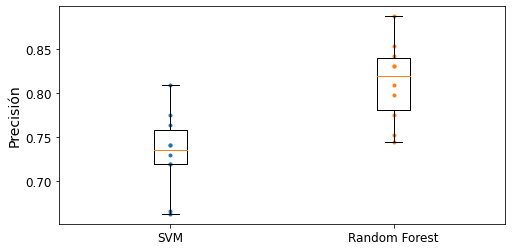

In [44]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Precisión", fontsize=14);

Para mejorar aún más este resultado, podríamos:

* Comparar muchos más modelos y ajustar hiperparámetros usando validación cruzada y grid search,
* Hacer más ingeniería de características, por  ejemplo:
  * reemplazar **SibSp** y **Parch** por sus sumas,
  * intentar identificar partes de nombres que correlacionen bien con el atributo **Survived** (por ejemplo, si el nombre contiene "Condesa", estonce parecería más probable que sobreviviera),
* intentar convertir los atributos numéricos a atributos categóricos: por ejemplo, diferentes grupos de edad tenían tasas de supervivencia muy diferentes (ver más abajo), por lo que puede ayudar a crear una categoría de edad y usarla en lugar de la edad. Del mismo modo, puede ser útil tener una categoría especial para las personas que viajan solas, ya que solo el 30% de ellas sobrevivió (ver más abajo).

In [45]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [46]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


## Clasificador de Spam

+ ***Descarga ejemplos de spam desde [Apache SpamAssassin’s public datasets.](https://spamassassin.apache.org/old/publiccorpus/)***

+ ***Descomprime el dataset y familiarízate con el formato de los datos***

+ ***Divide el dataset en un conjunto de entrenamiento y un conjunto de prueba***

+ ***Escribe un pipeline de preparación de datos para convertir cada email en un vector de características. Nuestro pipeline debe transformar un email en un vector (disperso) que indique la presencia o ausencia de cada palabra posible. Por ejemplo, si todos los emails solo contienen cuatro palabras, "Hello", "how", "are", "you", el correo electrónico "Hello you Hello Hello you" se convertiría en un vector \[1, 0, 0 , 1], que significa \["Hello" está presente, "how" está ausente, "are" está ausente, "you" está presente], o \[3, 0, 0, 2] si prefiere contar el número de ocurrencias de cada palabra.***

+ ***Es posible que queramos agregar hiperparámetros a nuestro pipeline para controlar si quitar o no los encabezados de los emails, convertir cada emails a minúsculas, eliminar la puntuación, reemplazar todas las URLs con "URL", reemplazar todos los números con "NUMBER" o incluso realizar la stemming (es decir, recorte las terminaciones de palabras; hay bibliotecas de Python disponibles para hacer esto).***

+ ***Entonces, entrena varios clasificadores y mira si puedes construir un buen clasificador de spam, con alta sensibilidad y precisión***

In [47]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("data", "spam")

def fetch_spam_data(spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()

In [48]:
fetch_spam_data()

Lo siguiente, vamos a cargar todos los emails:

In [49]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [50]:
len(ham_filenames)

2500

In [51]:
len(spam_filenames)

500

Podemos usar el módulo `email` de Python para analizar estos emails (esto maneja cabeceras, codificaciones, etc):

In [52]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [53]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

Echemos un vistazo a un ejemplo de email no-spam y un ejemplo de spam, para tener una primera impresión de como se muestran los datos:

In [54]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [56]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


Algunos emails son en realidad multipart, con imágenes y adjuntos (los cuales pueden tener sus propior adjuntos). Echemos un vistazo a varios de los tipos de estructuras que tenemos:

In [57]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [58]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [59]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [60]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

Parece que los emails buenos suelen ser texto sin formato, mientras que el spam tiene bastante HTML. Además, se firman bastantes emails con PGP, mientras que en el spam no. En resumen, parece que la estructura del correo electrónico es información útil para tener.

Ahora echemos un vistazo a las cabecera de los emails:

In [61]:
for header, value in spam_emails[0].items():
    print(header,":",value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

Probablemente haya mucha información útil aquí, como la dirección de correo electrónico del remitente (12a1mailbot1@web.de parece sospechosa), pero solo nos centraremos en el encabezado `Subject`:

In [62]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

OK, antes de aprender demasiado de los datos, no olvidemos dividirlos en un conjunto de entrenamiento y un conjunto de prueba:

In [63]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

OK, empecemos escribiendo las funciones de preprocesado. En primer lugar, necesitamos una función para convertir HTML a texto plano. Posiblemente la mejor forma de hacer esto es una la fantástica biblioteca [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/), pero nos gustaría evitar tener que añadir otra dependencia al proyecto, así que haremos una solución rápida usando expresiones regulares. La siguiente función primero elimina la sección `<head>`, luego convierte todas las etiquetas `<a>` a la palabra HYPERLINK, entonces se deshace de todas las etiquetas HTML, dejando solo el texto sin formato. Por legibilidad, también reemplaza las líneas múltiples en líneas sencillas y, finalmente, elimina las secuencias de escape de las entidades HTML (tales como `&gt;` or `&nbsp;`):

In [64]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

Veamos si funciona. Este es el HTML de un spam:

In [65]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

Y este es el texto plano resultante:

In [66]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

¡Genial! Ahora escribamos una función que tome un email como entrada y devuelva su contenido como texto sin formato, sea cual sea su formato:

In [67]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [68]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


Vamos a hacer stemming. Para hacer este trabajo necesitamos tener instalador Natural Language Toolkit ([NLTK](http://www.nltk.org/)). Si no lo tenemos, es tan simple como ejecutar el siguiente comando:

`$ pip3 install nltk`

In [69]:
try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


También necesitamos una forma de reemplazar URLs por la palabra "URL". Para ello, podríamos usar codificar [expresiones regulares](https://mathiasbynens.be/demo/url-regex), pero solo usaremos la librería [urlextract](https://github.com/lipoja/URLExtract). Podemos instalarla con el siguiente comando: 

`$ pip3 install urlextract`

In [70]:
try:
    import urlextract # may require an Internet connection to download root domain names
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


Estamos listos para poner todo esto en un transformador que usaremos para convertir emails en contadores de palabras. Tengamos en cuenta que dividimos las oraciones en palabras usando el método `split()` de Python, que usa espacios en blanco para los límites de las palabras. Esto funciona para muchos idiomas escritos, pero no para todos. Por ejemplo, los scripts chinos y japoneses generalmente no usan espacios entre palabras, y los vietnamitas a menudo usan espacios incluso entre sílabas. Está bien en este ejercicio, porque el conjunto de datos está (principalmente) en inglés.

In [71]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

Intentemos este transformador con algunos emails:

In [72]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

¡Esto parece correcto!

Ahora tenemos los recuentos de palabras y necesitamos convertirlos en vectores. Para esto, construiremos otro transformador cuyo método `fit()` construirá el vocabulario (una lista ordenada de las palabras más comunes) y cuyo método `transform()` usará el vocabulario para convertir el recuento de palabras en vectores. La salida es una matriz dispersa.

In [73]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [74]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.intc'>'
	with 20 stored elements in Compressed Sparse Row format>

In [75]:
X_few_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 11,  9,  8,  3,  1,  3,  1,  3,  2,  3],
       [67,  0,  1,  2,  3,  4,  1,  2,  0,  1,  0]], dtype=int32)

¿Qué significa esta matriz? Bueno, el 99 en la segunda fila, primera columna, significa que el segundo email contiene 99 palabras que no forman parte del vocabulario. El 11 al lado significa que la primera palabra en el vocabulario está presente 11 veces en este email. El 9 al lado significa que la segunda palabra está presente 9 veces, y así sucesivamente. Puedes mirar el vocabulario para saber de qué palabras estamos hablando. La primera palabra es "the", la segunda palabra es "of", etc.

In [76]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'url': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

Ahora estamos listos para entrenar nuestro primer clasificador de spam. Vamos a transformar el dataset completo:

In [77]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3, n_jobs=-1)
score.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished


0.9858333333333333

Más del 98.7%, ¡no está mal para un primer intento! Sin embargo, recuerda que estamos utilizando el conjunto de datos "fácil". Puedes probar con los conjuntos de datos más duros, los resultados no serán tan sorprendentes. Tendrías que probar varios modelos, seleccionar los mejores y ajustarlos mediante validación cruzada, etc.

Pero tenemos la foto, así que detengámonos ahora, e imprimamos la precisión / sensibilidad que obtenemos en el conjunto de prueba:

In [79]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("Precisión: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Sensibilidad: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precisión: 95.88%
Sensibilidad: 97.89%


C:\Program Files\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
